## MiniFlow
在学习Tensorflow之前， 实现MiniFlow.  
### 1. node
一个神经网络中，每个node都有输入和输出，每个node根据输入都会计算输出，因此，我们先来定义node:

In [1]:
class Node(object):
    def __init__(self, inbound_nodes=[]): 
        self.inbound_nodes = inbound_nodes
        self.outbound_nodes = []
        for n in self.inbound_nodes:
            n.outbound_nodes.append(self)
        self.value = None

### Forward propagation
为了计算一个node， 需要知道它的输入，而输入又依赖于其他节点的输出，这种为了计算当前节点而求其所有前置节点的技术叫拓扑排序- topological sort，效果如下图：

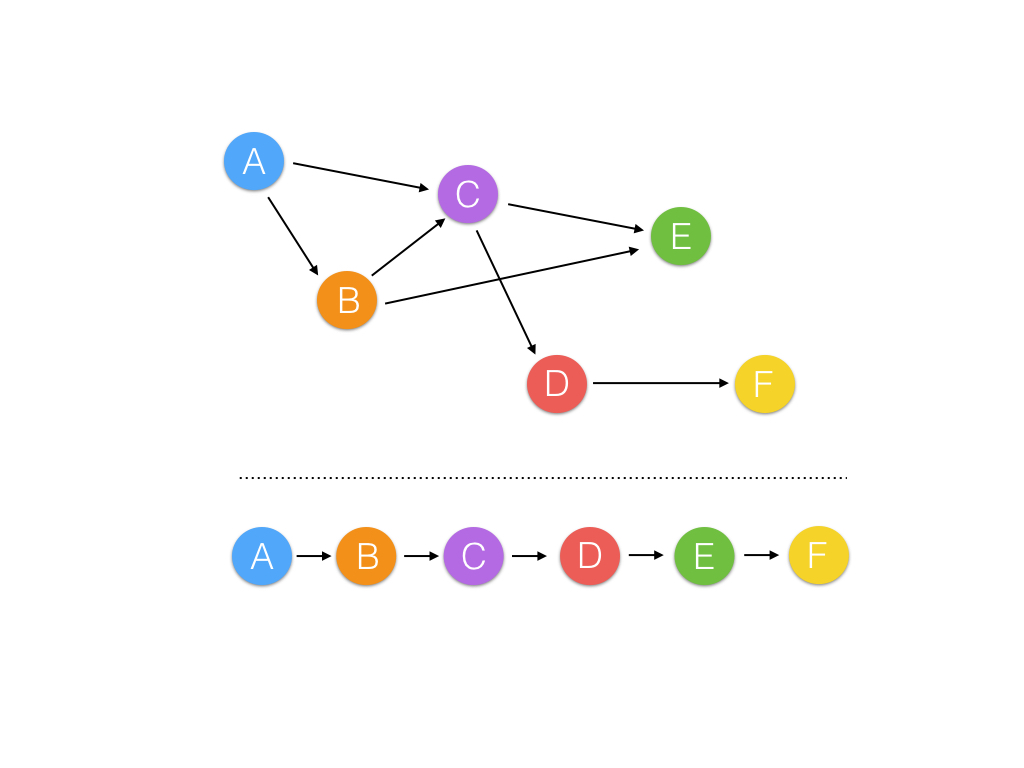

In [2]:
from IPython.display import Image
Image('topological-sort.png')

上面为了计算最后的Node F, 我们给出了一个可行的计算顺序。此处，直接给出一个算法，Kahn's Algorithm,代码如下：

In [3]:
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] ={'in': set(), 'out': set()}
        for m in n.outbound_nodes:
            if m not in G:
                G[m] = {'in': set(), 'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    
    L = []
    S = set(input_nodes)
    while len(S)>0:
        n=S.pop()
    
        if isinstance(n,Input):
            n.value = feed_dict[n]
            
        L.append(n)
        for m in n.outbound_nodes:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            
            if len(G[m]['in']) == 0:
                S.add(m)
                
    return L

def forward_pass(output_node, sorted_nodes):
    for n in sorted_nodes:
        n.forward()
        
    return output_node.value

下面来实现一些简单的Node类型，第一个是Input类型：

In [4]:
class Input(Node):
    def __init__(self):
        Node.__init__(self)
    def forward(self, value = None):
        if value is not None:
            self.value = value

下面是Mul类型：

In [5]:
class Mul(Node):
    def __init__(self, *inputs):
        Node.__init__(self,inputs)
        
    def forward(self):
        sum = 1.0
        for n in self.inbound_nodes:
            sum *= n.value
        self.value = sum

具体的用法如下：

In [6]:
x, y, z = Input(), Input(), Input()
f = Mul(x,y,z)
feed_dict = {x: 4, y: 5, z: 10}
graph = topological_sort(feed_dict)
output = forward_pass(f, graph)

print('{} * {} * {} = {}(according to miniflow)'.format(feed_dict[x],
                                                       feed_dict[y],
                                                       feed_dict[z],
                                                       output))

4 * 5 * 10 = 200.0(according to miniflow)


下面来实现稍微复杂些的Node类型：Linear Node

In [8]:
class Linear(Node):
    def __init__(self, inputs, weights, bias):
        Node.__init__(self,[inputs, weights, bias])
    
    def forward(self):
        inputs = self.inbound_nodes[0].value
        weights = self.inbound_nodes[1].value
        bias = self.inbound_nodes[2].value
        
        sum = 0
        for i in range(len(inputs)):
            sum += inputs[i]*weights[i]
            
        self.value = sum + bias

In [9]:
inputs, weights, bias = Input(), Input(), Input()

f = Linear(inputs, weights, bias)
feed_dict = {
    inputs: [6, 20, 4],
    weights: [0.5, 0.25, 1.5],
    bias: 2
}

graph = topological_sort(feed_dict)
output = forward_pass(f, graph)

print(output)

16.0


定义Sigmoid Node

In [10]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        
    def _sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def forward(self):
        input_value = self.inbound_nodes[0].value
        self.value = self._sigmoid(input_values)

### 2.定义cost函数
训练神经网络时，我们可以利用均方误差MSE来衡量输出准确性。

In [11]:
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y,a])
        
    def forward(self):
        y = self.inbound_nodes[0].value.reshape(-1,1)
        a = self.inbound_nodes[1].value.reshape(-1,1)
        
        m = len(y)
        sum = 0
        for (yi,ai) in zip(y,a):
            sum += np.square(yi-ai)
        self.value = sum/m

### 3.定义反向传播

In [12]:
import numpy as np

class Node(object):
    def __init__(self, inbound_nodes = []):
        self.inbound_nodes = inbound_nodes
        self.value = None
        self.outbound_nodes = []
        self.gradients = {}
        for node in inbound_nodes:
            node.outbound_nodes.append(self)
        
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)
        
    def forward(self):
        pass
    
    def backward(self):
        self.gradients = {self: 0}
        # 输入节点的梯度等于所有输出的梯度相加
        for n in self.outbound_nodes:
            grad_cost = n.gradients[self]
            self.gradients[self] += grad_cost *1
            
class Linear(Node):
    def __init__(self, X, W, b):
        Node.__init__(self, [X, W, b])
        
    def forward(self):
        X = self.inbound_nodes[0].value
        W = self.inbound_nodes[1].value
        b = self.inbound_nodes[2].value
        
        self.value = np.dot(X, W) +b
    
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        for n in self.outbound_nodes:
            
            grad_cost = n.gradients[self]
            # y = XW+b
            # 分别计算y 相对于每个输出节点的梯度
            # delta_x =W
            self.gradients[self.inbound_nodes[0]] += np.dot(grad_cost,
                                                             self.inbound_nodes[1].value.T)
            # delta_w = x
            self.gradients[self.inbound_nodes[1]] += np.dot(self.inbound_nodes[0].value.T, grad_cost)
            
            # delta_b = 1
            self.gradients[self.inbound_nodes[2]] += np.sum(grad_cost,axis=0, keepdims = False)
            
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        
    def _sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def forward(self):
        input_value = self.inbound_nodes[0].value
        self.value = self._sigmoid(input_value)
        
    def backward(self):
        # Initialize the gradients to 0
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        
        for n in self.outbound_nodes:
            # Get the partial of the cost with respect to this node
            grad_cost = n.gradients[self]
            
            sigmoid = self.value
            self.gradients[self.inbound_nodes[0]] = sigmoid*(1-sigmoid)*grad_cost
            
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y,a])
        
    def forward(self):
         
        y = self.inbound_nodes[0].value.reshape(-1,1)
        
        a = self.inbound_nodes[1].value.reshape(-1,1)
        
        self.m = self.inbound_nodes[0].value.shape[0]
        
        self.diff = y-a
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        
        self.gradients[self.inbound_nodes[0]] = (2/self.m) *self.diff
        self.gradients[self.inbound_nodes[1]] = (-2/self.m) *self.diff
        
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] ={'in': set(), 'out': set()}
        for m in n.outbound_nodes:
            if m not in G:
                G[m] = {'in': set(), 'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    
    L = []
    S = set(input_nodes)
    while len(S)>0:
        n=S.pop()
    
        if isinstance(n,Input):
            n.value = feed_dict[n]
            
        L.append(n)
        for m in n.outbound_nodes:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            
            if len(G[m]['in']) == 0:
                S.add(m)
                
    return L

def forward_and_backward(graph):
    # Forward pass
    for n in graph:
        n.forward()
        
    # Backward pass
    for n in graph[::-1]:
        n.backward()        

上面定义了所有需要的节点和函数，可以得出下面的方法：

In [13]:
X, W, b = Input(), Input(), Input()
y= Input()

f = Linear(X, W, b)
a = Sigmoid(f)
cost = MSE(y, a)

X_ = np.array([[-1.,-2.],[-1,-2]])
W_ = np.array([[2.],[3.]])
b_ = np.array([-3.])
y_ = np.array([1,2])

feed_dict = {
    X: X_,
    y: y_,
    W: W_,
    b: b_,
}

graph = topological_sort(feed_dict)
forward_and_backward(graph)

# return the gradients for each Input
gradients = [t.gradients[t] for t in [X,y,W,b]]
print(gradients)

[array([[ -3.34017280e-05,  -5.01025919e-05],
       [ -6.68040138e-05,  -1.00206021e-04]]), array([[ 0.9999833],
       [ 1.9999833]]), array([[  5.01028709e-05],
       [  1.00205742e-04]]), array([ -5.01028709e-05])]


### 4.随机梯度下降

In [24]:
def sgd_update(trainables, learning_rate = 1e-2):
    for n in trainables:
        n.value -= learning_rate * n.gradients[n]
        
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

## Load data
data = load_boston()
X_ = data['data']
Y_ = data['target']

## Normalize data

X_ = (X_ - np.mean(X_, axis = 0))/np.std(X_, axis = 0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden,1)
b2_ = np.zeros(1)

# Neural Network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs =10
# Total number of examples

m = X_.shape[0]
batch_size = 11
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print('Total number of examples ={}'.format(m))

#step 4

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        # reset value of X, y Inputs
        X.value = X_batch
        y.value = y_batch
        
        #step 2
        forward_and_backward(graph)
        
        # step 3
        sgd_update(trainables)
        
        loss += graph[-1].value
        
    print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))

Total number of examples =506
Epoch: 1, Loss: 123.992
Epoch: 2, Loss: 34.559
Epoch: 3, Loss: 27.261
Epoch: 4, Loss: 20.321
Epoch: 5, Loss: 28.263
Epoch: 6, Loss: 26.027
Epoch: 7, Loss: 19.284
Epoch: 8, Loss: 16.669
Epoch: 9, Loss: 16.532
Epoch: 10, Loss: 17.216
